In [1]:
%load_ext autoreload
%autoreload 2
from funcs import train_ann, eval_ann, eval_snn
import os
from Models import modelpool
from Preprocess import datapool
from utils import replace_maxpool2d_with_avgpool2d, replace_qcfs_with_sn, replace_relu_with_qcfs
import torch
import matplotlib.pyplot as plt
import numpy as np

2024-11-12 09:20:25.932218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 09:20:25.951226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {DEVICE}!")
DATA_NAME = 'cifar10'
MODEL_NAME = 'resnet20'
EPOCHS = 200
BS = 128
LR = 0.01
L = 8
SNN_MODELS = ['if', 'rt']

# Load data
data_train, data_test = datapool(DATA_NAME, BS)
loss_fn = torch.nn.CrossEntropyLoss()

# Load model
model = modelpool(MODEL_NAME, DATA_NAME)
model = replace_maxpool2d_with_avgpool2d(model)
model = replace_relu_with_qcfs(model, L=L)

Using device cuda!
Files already downloaded and verified
Files already downloaded and verified


In [3]:
file_path = f'./saved_models/{MODEL_NAME}_{DATA_NAME}.pth'
if os.path.exists(file_path):
	# Load the model weights
	model.load_state_dict(torch.load(file_path, weights_only=True))
	acc, loss = eval_ann(data_test, model, loss_fn, DEVICE)
else:
	# Train the model if it doesn't exist
	model = model.to(DEVICE)
	acc, loss, model = train_ann(data_train, data_test, model, EPOCHS, DEVICE, loss_fn, lr=LR, save=f'{MODEL_NAME}_{DATA_NAME}')
	
	# Plot training data
	plt.figure(figsize=(8, 4), dpi=200)
	plt.plot(acc)
	plt.title("Accuracy")
	plt.xlabel("Epochs")

	plt.figure(figsize=(8, 4), dpi=200)
	plt.plot(loss)
	plt.title("Loss")
	plt.xlabel("Epochs")

In [4]:
TAU = 4
DT = 0.1
SIGMA = 0.0

T = int(L / DT) * 10
TIME = np.arange(1, T + 1) * DT

snn_acc: dict = {}
snn_loss: dict = {}
for snn_model in SNN_MODELS:
	model = modelpool(MODEL_NAME, DATA_NAME)
	model = replace_maxpool2d_with_avgpool2d(model)
	model = replace_relu_with_qcfs(model, L=L)
	model.load_state_dict(torch.load(file_path, weights_only=True))
	model = replace_qcfs_with_sn(model, tau=TAU, sn_type=snn_model, noise=SIGMA, dt=DT)
	model = model.to(DEVICE)
	snn_acc[snn_model], snn_loss[snn_model] = eval_snn(data_test, model, loss_fn, DEVICE, T, batches=1, dt=DT)

  0%|          | 0/78 [00:00<?, ?it/s]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')


  0%|          | 0/78 [00:00<?, ?it/s]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')


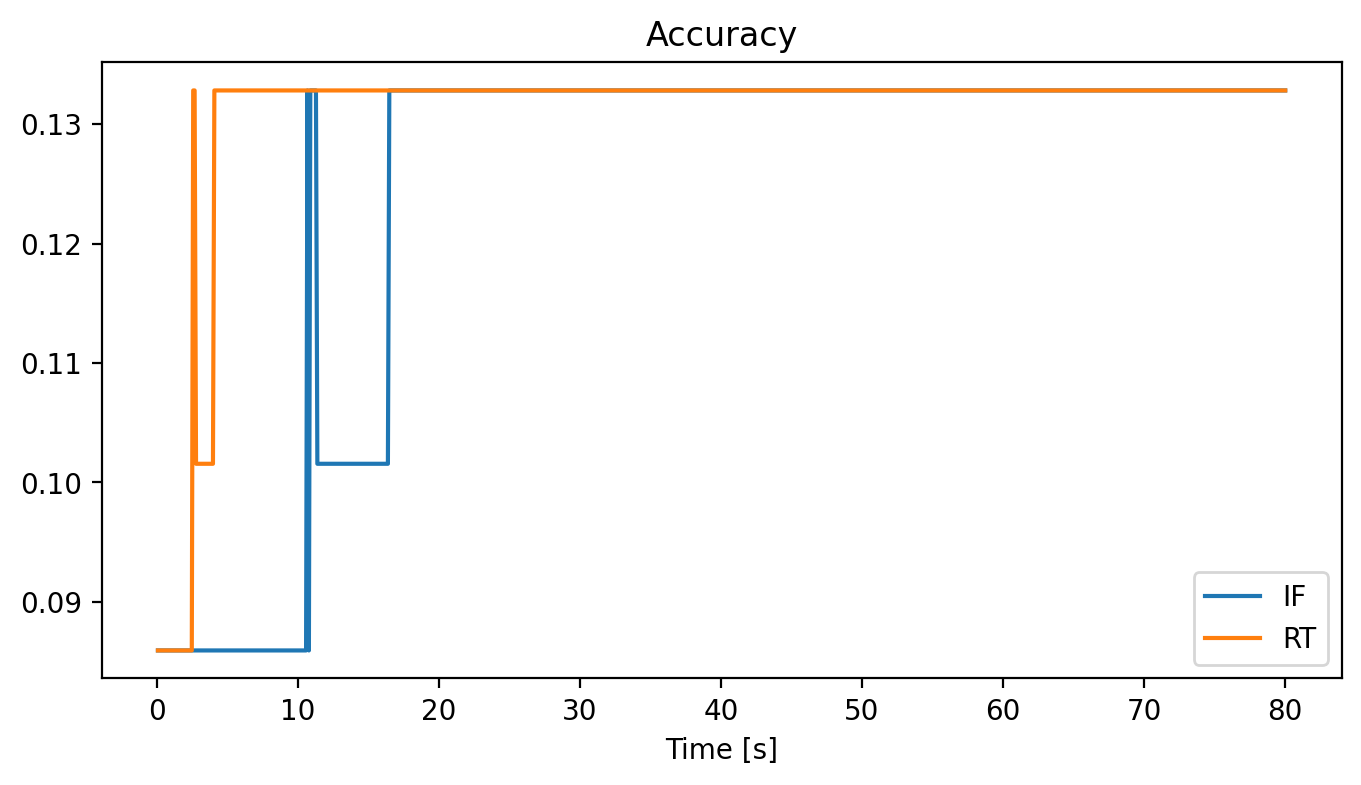

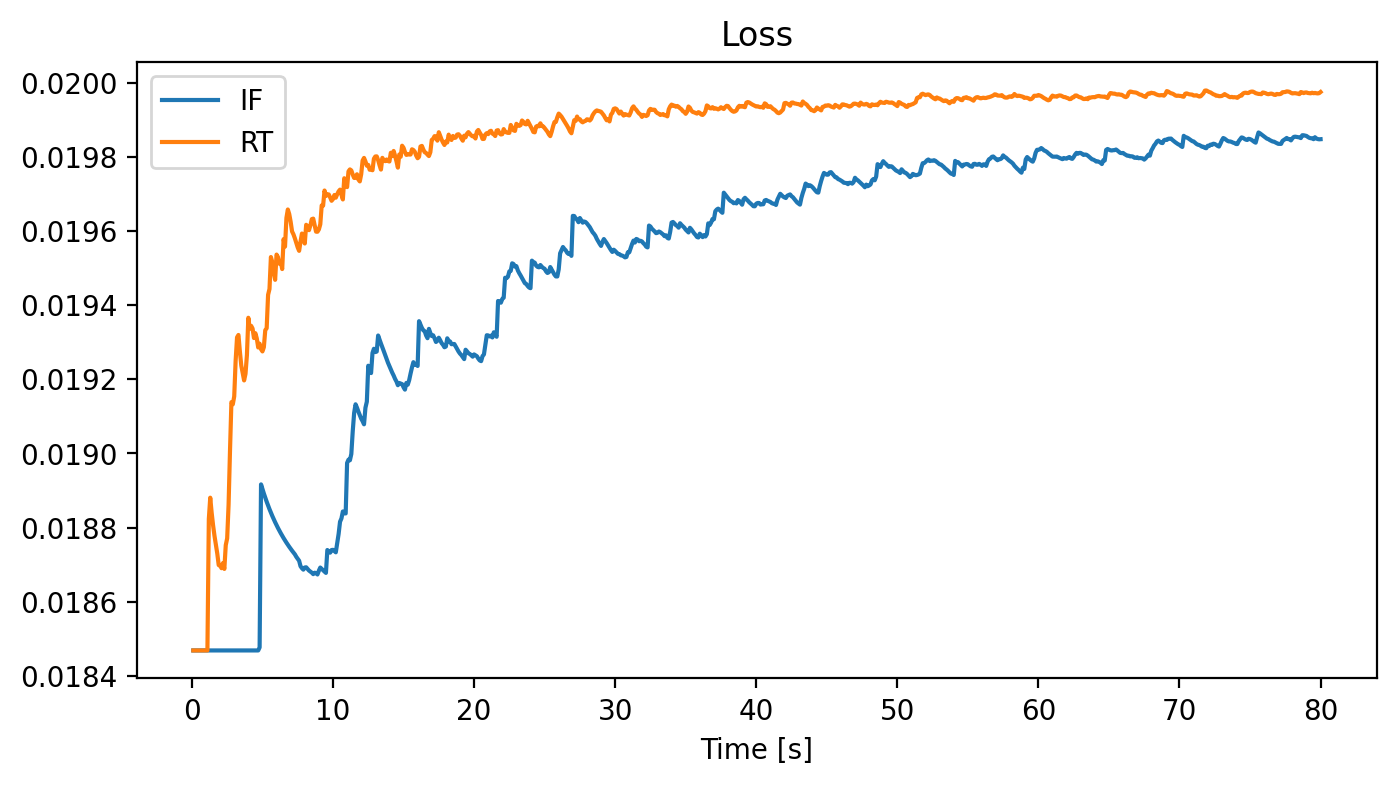

In [5]:
plt.figure(figsize=(8, 4), dpi=200)
for snn_model in SNN_MODELS:
	plt.plot(TIME, snn_acc[snn_model], label=snn_model.upper())
plt.title("Accuracy")
plt.xlabel("Time [s]")
plt.legend()

plt.figure(figsize=(8, 4), dpi=200)
for snn_model in SNN_MODELS:
	plt.plot(TIME, snn_loss[snn_model], label=snn_model.upper())
plt.title("Loss")
plt.xlabel("Time [s]")
plt.legend()